# SOCI 415 Network Analysis - CBDB Dataset

prAxIs UBC Team <br> *Alex Ronczewski*  
2025-08-24

# 0.0 Prerequisites

-   SOCI 415 Network Analysis Intro Notebook
-   Kinmatrix Dataset Notebook

The China Biographical Database is a freely accessible relational
database with biographical information about approximately 641,568
individuals as of August 2024, currently mainly from the 7th through
19th centuries. It was developed as a collaborative project between
scholars at Harvard University, Academia Sinica, and Peking University.
The data is useful for statistical, social network, and spatial analysis
as well as serving as a biographical reference for Chinese History.

This dataset has many variables and is far more complex than the
KINMATRIX Dataset we have used before, the dataset is far larger and
contains more traditional networks as opposed to KINMATRIX’s ego
networks. If you wish to read more about the structure of the dataset
you can follow the link [Structure of
CBDB](https://projects.iq.harvard.edu/cbdb/structure-cbdb).

# 1.0 Data Loading and Intro

As with all of our notebooks so far we will begin with loading all of
our libraries. This library list is similar to the one used in the
KINMATRIX data analysis.

In [1]:
#Libraries listed below
import sqlite3
import pandas as pd
import networkx as nx #Our Python network analysis library
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import random
from community import community_louvain
import numpy as np
from collections import Counter
from pyvis.network import Network
from scipy import stats
import seaborn as sns
from collections import OrderedDict

Now that we have all of the libraries loaded in for our analysis we can
load our data. The dataset is a .db file meaning it is a database. The
CBDB data is extensive and has lots of variables within it, in order to
access them we have to choose a table from our .db file. A table is a
structured collection of data organized in rows and columns, similar to
a spreadsheet. Each table contains records (rows), and every record has
fields (columns).

Display all of the tables in the dataset .db file.

In [2]:
db_path = r'datasets\latest.db' #path
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in database:", tables)

conn.close()

The output of the cell above is a list of all of the tables in the
dataset and we can see that the list is extensive. The one we are most
intested in is called KIN_DATA. It contains the necessary information to
construct our network. We will now load the table. The output of this
cell will be all of the variables within the table ‘KIN_DATA.’

In [3]:
# Connect to the database
conn = sqlite3.connect(db_path)

df = pd.read_sql_query("SELECT * FROM KIN_DATA", conn)

# Show the first few rows
print(df.head())

conn.close()

We can see from the output that the dataset contains both English and
Chinese data so we will have to be careful to select the English
language variables. We have now loaded the correct data and just like
with the KINMATRIX Dataset we will build a NetworkX Graph and print the
number of nodes and edges.

In [4]:
# Create an empty graph
G = nx.Graph()

# Add edges with kinship type as edge attribute
for _, row in df.iterrows():
    person = row['c_personid']
    kin = row['c_kin_id']
    kin_type = row['c_kin_code']
    G.add_edge(person, kin, kinship=kin_type)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

We have over 278,000 nodes and a similar amount of edges. This is a far
bigger dataset than we have previously used. The is a very extensive
dataset where one of these networks is larger than all of the networks
for the KINMATRIX Dataset.

We already ran into computational problem when analyzing the KINMATRIX
Dataset so we will have to be careful. We can not visualize the full
network and all complex calculations like centrality will take a long
time.

# 2.0 Louvain and Community Clusters

The first thing we will do for our analysis is look for are smaller
sub-groups. This is analysis we could not do for the KINMATRIX Dataset
as it was an ego-centric network. This is very popular technique in
network analysis as it helps uncover hidden group structure in very
expansive and complex networks.

In our case large networks (like the CBDB) can be overwhelming and
computationally intensive to study. Unlike the KINMATRIX dataset where
the data was naturally divided into countries and provinces there are
far less clear subgroups in this dataset. By identifying clusters,
sociologists can summarize, visualize, and understand the major
subgroups and their relationships, making the network more
interpretable. To preform this community analysis we will need to
introduce some more terminology.

**Cohesive subgroups** in network analysis refer to clusters of nodes
within a network that are more *densely connected to each other than to
the rest of the network*. These subgroups indicate areas of high
interaction or strong relationships within the larger network.
Identifying cohesive subgroups helps in understanding the structure and
dynamics of the network, such as how information or influence flows
within and between these groups. The process of finding cohesive
subgroups within networks is called **cohesive group analysis**.

A **clique** is a subset of nodes within a graph where every node is
directly connected to every other node in the subset. This means that in
a clique, all possible edges between the nodes are present, making it a
maximally connected subgraph. All nodes are that are by themselves are
inherently a clique (a 1-clique)

Let’s see what this look like on an example network before moving
towards our real data.

In [5]:
#Create our network
G_cliques_example = nx.Graph()
edges_list = [(0,1),(0,2),(0,3),(0,4),(1,2),(2,3),(3,4),(1,4),(2,4),(1,3),(4,5),(5,6)]
G_cliques_example.add_edges_from(edges_list)
pos = nx.spring_layout(G_cliques_example, seed=1000)

#Find our cliques and print where they are
cliques = [x for x in nx.find_cliques(G_cliques_example)]
print(cliques)

#Draw our graph      
nx.draw(G_cliques_example,pos=pos, with_labels=True, edgecolors="black", node_color = "bisque", node_size=800)

We can see that there are three cliques in this network:
$(4, 0, 1, 2, 3)$, $(4, 5)$, and $(6, 5)$:

We can colour them green to be more easily identifiable.

In [6]:
#Set the figure size (24,6) not (8,6) because we have 3 graphs to show
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
fig.set_facecolor('lightblue')

#Create our network
G_cliques_example = nx.Graph()
edges_list = [(0,1),(0,2),(0,3),(0,4),(1,2),(2,3),(3,4),(1,4),(2,4),(1,3),(4,5),(5,6)]
G_cliques_example.add_edges_from(edges_list)
pos = nx.spring_layout(G_cliques_example, seed=1000)

#Find our cliques and print them
cliques = [x for x in nx.find_cliques(G_cliques_example)]
print(cliques)

#Colour our cliques
clique_1 = ["mediumseagreen", "mediumseagreen", "mediumseagreen", "mediumseagreen", "mediumseagreen", "bisque", "bisque"]
clique_2 = ["bisque", "bisque", "bisque",  "bisque", "mediumseagreen", "mediumseagreen", "bisque"]
clique_3 = ["bisque", "bisque", "bisque", "bisque",  "bisque", "mediumseagreen", "mediumseagreen"]

#Draw our cliques       
nx.draw(G_cliques_example, ax=axes[0], pos=pos, with_labels=True, edgecolors="black", node_color = clique_1, node_size=800)
nx.draw(G_cliques_example, ax=axes[1], pos=pos, with_labels=True, edgecolors="black", node_color = clique_2, node_size=800)
nx.draw(G_cliques_example, ax=axes[2], pos=pos, with_labels=True, edgecolors="black", node_color = clique_3, node_size=800)

Nodes can also be in multiple cliques.

In [7]:
#Create our example graph
G_cliques_example = nx.Graph()
edges_list = [(0,1),(0,2),(0,3),(0,4),(1,2),(2,3),(3,4),(1,4),(2,4),(1,3),(4,5),(5,6)]
G_cliques_example.add_edges_from(edges_list)
pos = nx.spring_layout(G_cliques_example, seed=1000)

#Find the cliques
cliques = [x for x in nx.find_cliques(G_cliques_example)]
print(cliques)

#For loop
node_counts = {}
for clique in cliques: #for each clique in the list of cliques...
    for node in clique: # for each node in each clique...
        if node in node_counts: #checks whether the current node already exists as a key in the node_counts dictionary
            node_counts[node] += 1 #if it is in the dictionary, increase it's value by 1
        else:
            node_counts[node] = 1 #if it isn't, dont change

#Colour our nodes
colors = []
for node in G_cliques_example.nodes():
    if node_counts[node] == 1:
        colors.append("lightgreen")
    elif node_counts[node] == 2:
        colors.append("forestgreen")
    elif node_counts[node] == 3:
        colors.append("orange")
    else:
        colors.append("red")

#Draw our network           
nx.draw(G_cliques_example,pos=pos, with_labels=True, edgecolors="black", node_color = colors, node_size=800)
patch_green = mpatches.Patch(color='lightgreen', label='node in one clique') 
patch_forest = mpatches.Patch(color='forestgreen', label='node in two cliques') 
plt.legend(handles=[patch_green, patch_forest])
plt.show()

## 2.1 Network-level analysis: Clusters and clustering coefficients

A **cluster** (also known as a community) is a set of nodes in a graph
that are densely connected to each other but sparsely connected to nodes
in other clusters. For example, in a social network, a cluster might
represent a group of people who frequently interact with each other but
have fewer interactions with people outside the group. **Community
detection** is the process of finding such communities within nodes.

Before diving into community detection, we first need to understand
modularity. **Modulaity** is a numerical measure for the community
structure of a graph: it compares the density of edges within the
communities of a network to the density of edges between communities. A
positive modularity value suggests a strong community structure, while
values closer to zero or negative indicate that the divisions are no
better than random.

The Louvain algorithm is a community detection method in networks that
aims to optimize modularity. By optimizing modularity, the Louvain
algorithm effectively uncovers natural divisions in the network where
connections are dense within clusters and sparse between them, thus
identifying meaningful community structures.

First, each node is assigned to its own community, and nodes are then
iteratively moved to neighboring communities if it increases the
modularity. In the second phase, the algorithm creates a new network
where each community from the first phase is treated as a single node,
and the process is repeated. This hierarchical approach continues until
no further modularity improvements can be made, resulting in a final set
of communities that maximize modularity.

Let’s first try running the Louvain Algorithm on a random graph to
demonstrate how it works before running it on our real data.

In [8]:
#Set the seed so it is reproducable
random.seed(1)

n = 20  # number of nodes
d = 3   # degree of each node

# Generate the random regular graph
rr_graph = nx.random_regular_graph(d, n)

partition = community_louvain.best_partition(rr_graph)
pos = nx.spring_layout(rr_graph, seed=42)
num_communities = max(partition.values()) + 1
cmap = cm.get_cmap('viridis', num_communities)
nx.draw_networkx_nodes(
    rr_graph, pos, node_size=40, cmap=cmap, node_color=list(partition.values())
)
nx.draw_networkx_edges(rr_graph, pos, alpha=0.5)
plt.show()

We can see by the node coloring that by optimizing modularity the
Louvain Algorithm has found smaller subgroups within our random network.
Now we can try it on our real data.

## 2.2 Louvain Run on Real Data

As with before we will set a random seed so that the analysis is
reporducable. We will also print out average community size along with
the size of the largest and smallest communities. We will also print the
top 10 largest communities and their sizes.

We will also be working with the largest connected component for this
analysis.

In [9]:
#Set a seed for reproducability of our results
np.random.seed(1)

# Load kinship data into DataFrame
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT c_personid, c_kin_id, c_kin_code FROM KIN_DATA", conn)
conn.close()

# Build the Graph
G = nx.Graph()
for _, row in df.iterrows():
    person = row['c_personid']
    kin = row['c_kin_id']
    kin_type = row['c_kin_code']
    G.add_edge(person, kin, kinship=kin_type)

# Work with the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()
print(f"Largest connected component nodes: {G_sub.number_of_nodes()}")

# Run Louvain Community Detection
print("Running Louvain algorithm...")
partition = community_louvain.best_partition(G_sub)

# Community Analysis Output
num_communities = len(set(partition.values()))
print(f"In our data Louvain has detected {num_communities} communities.")

# Count community sizes
community_sizes = Counter(partition.values())
print(f"\nMetrics about Community size:")
print(f"Average community size: {np.mean(list(community_sizes.values())):.1f}")
print(f"Largest community: {max(community_sizes.values())} people")
print(f"Smallest community: {min(community_sizes.values())} people")

#Show top 10 largest communities
print(f"\nLargest Communities:")
for i, (comm_id, size) in enumerate(community_sizes.most_common(10)):
    print(f"Community {comm_id}: {size:,} people")

# Calculate modularity
modularity = community_louvain.modularity(partition, G_sub)
print(f"\nModularity Score: {modularity:.4f}")
print("(Higher modularity indicates stronger community structure)")

#Distributon Histogram of Community Size
fig, ax = plt.subplots(figsize=(15, 12))
fig.suptitle('CBDB Kinship Network Community Analysis', fontsize=16, fontweight='bold')

# Community size histogram
ax.hist(list(community_sizes.values()), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax.set_xlabel('Community Size (number of people)')
ax.set_ylabel('Number of Communities')
ax.set_title('Distribution of Community Sizes')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

From the visualization we can see most communities are around 200 - 400
nodes in size.

Lets look at two of these communities in more detail, we will look at
one average sized one and one large one.

The two we will use are:

-   Community 20: 703 nodes with 940 edges
-   Community 125: 308 nodes with 392 edges

In [10]:
np.random.seed(1)

def visualize_cbdb_community(G_sub, partition, community_id, max_nodes=1000):
    community_nodes = [str(node) for node, comm_id in partition.items() if comm_id == community_id]
    
    print(f"Community {community_id}: {len(community_nodes)} people")
    
    # Create subgraph with string node IDs
    subgraph = G_sub.subgraph([int(node) for node in community_nodes])
    print(f"Showing {len(community_nodes)} people, {subgraph.number_of_edges()} relationships")
    
    net = Network(height="700px", width="100%", bgcolor="#ffffff", notebook=True)
    
    for node in community_nodes:
        degree = subgraph.degree[int(node)] 
        size = max(15, min(35, 15 + degree))
        net.add_node(str(node), 
                     label=str(node), 
                     size=size, 
                     color="#3498db",
                     title=f"Person {node}\nConnections: {degree}")
    
    for u, v, data in subgraph.edges(data=True):
        net.add_edge(str(u), str(v), color="#cccccc", title=f"Kinship: {data.get('kinship','family')}")
    
    filename = f"community_{community_id}.html"
    net.show(filename)
    print(f"Interactive network: {filename}")

#Run the function
visualize_cbdb_community(G_sub, partition, 20)
visualize_cbdb_community(G_sub, partition, 125)

We will again use a PyVis visualization, just like with the KINMATRIX
Visualizations we can zoom and pan around and hover on the nodes. This
time you can also drag the nodes and the surrounding nodes will move
like bacteria under a microscope.

## 2.3 Macro Stats and Dynasties

To get a better understanding of our communities we will look at some
summary statistics. Let’s briefly define what these macro statistics
will be:

-   Diameter: The longest shortest path between any two nodes in the
    network or component. This is a way to measure how “wide” our
    network is.
-   Average Path Lenght: The average number of steps along the shortest
    paths for all possible pairs of nodes in the graph
-   Average Clustering: The likelihood that any two neighbors of a node
    are also connected to each other. Higher values mean people in the
    community tend to form “groups”.

We will also look at degree centrality, density and number of nodes.

In [11]:
np.random.seed(1)

def macro_stats(G_sub, partition, community_id):
    nodes = [n for n, c in partition.items() if c == community_id]
    subg = G_sub.subgraph(nodes)
    stats = {}

    if nx.is_connected(subg):
        stats['diameter'] = nx.diameter(subg)
        stats['avg_path_length'] = nx.average_shortest_path_length(subg)
    else:
        # statistics of largest connected component only
        lcc = subg.subgraph(max(nx.connected_components(subg), key=len))
        stats['diameter'] = nx.diameter(lcc)
        stats['avg_path_length'] = nx.average_shortest_path_length(lcc)

    degrees = dict(subg.degree())
    max_degree = max(degrees.values())
    n = len(degrees)
    if n > 1:
        degree_centralization = sum(max_degree - d for d in degrees.values()) / ((n-1)*(n-2))
    else:
        degree_centralization = 0
    stats['degree_centralization'] = degree_centralization
    stats['avg_clustering'] = nx.average_clustering(subg)
    stats['density'] = nx.density(subg)
    stats['n_nodes'] = n
    return stats

#Print:
stats_20 = macro_stats(G_sub, partition, 20)
stats_125 = macro_stats(G_sub, partition, 125)
print("Community 50 macro stats:", stats_20)
print("Community 125 macro stats:", stats_125)

We now have more quantifiable metrics for our visualizations. Let’s
contunue our analysis with finding which dynasties these communities are
primarily from.

In [12]:
np.random.seed(1)

# Community 125
personids_125 = [n for n, c in partition.items() if c == 125]
conn = sqlite3.connect(db_path)
ids_tuple_125 = tuple(personids_125)
query_125 = f'''
    SELECT c_personid, c_dy FROM BIOG_MAIN
    WHERE c_personid IN {ids_tuple_125}
'''
df_dyn_125 = pd.read_sql_query(query_125, conn)

# Community 20
personids_20 = [n for n, c in partition.items() if c == 20]
ids_tuple_20 = tuple(personids_20)
query_20 = f'''
    SELECT c_personid, c_dy FROM BIOG_MAIN
    WHERE c_personid IN {ids_tuple_20}
'''
df_dyn_20 = pd.read_sql_query(query_20, conn)
conn.close()

# Show the most common dynasty codes
print("Community 125 dominant dynasties:")
print(df_dyn_125['c_dy'].value_counts().head(3))

print("Community 20 dominant dynasties:")
print(df_dyn_20['c_dy'].value_counts().head(3))

We can see that Community 125 is primarily from Dynasty 6, and Community
50 is primarily from Dynasty 15, but this does not tell us much we need
to translate 6 and 15 into real dynasty names. These values represent
names of real dynasties, but without the key this output does not mean
anything.

Lets now map these values to real dynasty names.

In [13]:
np.random.seed(1)

conn = sqlite3.connect(db_path)
dynasty_mapping = pd.read_sql_query('SELECT c_dy, c_dynasty FROM DYNASTIES', conn)
conn.close()

def get_dynasty_breakdown(df_dyn, dynasty_mapping):
    df_merged = df_dyn.merge(dynasty_mapping, on='c_dy', how='left')
    return df_merged['c_dynasty'].value_counts()  

print("Community 125 top 3 dynasties:")
print(get_dynasty_breakdown(df_dyn_125, dynasty_mapping).head(3))

print("Community 20 top 3 dynasties:")
print(get_dynasty_breakdown(df_dyn_20, dynasty_mapping).head(3))

Now we know that Community 125 is primarily made up of individuals from
the Tang Dynasty and Community 50 is primarily made up of individuals
from the Song Dynasty.

## 2.4 Coloring Nodes

Like with the KINMATRIX Dataset we will color our Pyvis visualizations
by a variable of interest. In this case we will color Community 125 by
gender where male is purple and women are yellow. There are no unknown
gender variables in either of these communities so we can just have two
colors in our color map.

In [14]:
np.random.seed(1)

# Get all node and person id's
all_personids = list(set([n for n in partition.keys()]))

conn = sqlite3.connect(db_path)
query = f'''
    SELECT c_personid, c_female FROM BIOG_MAIN
    WHERE c_personid IN ({','.join(str(pid) for pid in all_personids)})
'''
df_gender = pd.read_sql_query(query, conn)
conn.close()

# Function to map female/male from number 1/0
def sex_label(val):
    return 'female' if val == 1 else ('male' if val == 0 else 'unknown')

gender_dict = {row['c_personid']: sex_label(row['c_female']) for _, row in df_gender.iterrows()}

def visualize_cbdb_community_gender(G_sub, partition, community_id, gender_dict, max_nodes=1000):
    community_nodes = [str(node) for node, comm_id in partition.items() if comm_id == community_id]
    print(f"Community {community_id}: {len(community_nodes)} people")
    if len(community_nodes) > max_nodes:
        print(f"Sampling {max_nodes} nodes for performance...")
        subgraph_full = G_sub.subgraph([int(node) for node in community_nodes])
        degrees = dict(subgraph_full.degree())
        sorted_nodes = sorted(community_nodes, key=lambda x: degrees.get(int(x), 0), reverse=True)
        community_nodes = sorted_nodes[:max_nodes//2] + random.sample(sorted_nodes[max_nodes//2:], max_nodes//2)

    subgraph = G_sub.subgraph([int(node) for node in community_nodes])
    print(f"Showing {len(community_nodes)} people, {subgraph.number_of_edges()} relationships")
    net = Network(height="700px", width="100%", bgcolor="#ffffff", notebook=True)

    color_map = {'male': '#800080',   # purple
             'female': '#FFFF00'}  # yellow 
    for node in community_nodes:
        gender = gender_dict.get(int(node), 'unknown')
        degree = subgraph.degree[int(node)]
        size = max(15, min(35, 15 + degree))
        net.add_node(str(node), 
                     label=str(node),
                     size=size,
                     color=color_map.get(gender, '#bdbdbd'),
                     title=f"Person {node}\nConnections: {degree}\nGender: {gender}")

    for u, v, data in subgraph.edges(data=True):
        net.add_edge(str(u), str(v), color="#cccccc", title=f"Kinship: {data.get('kinship','family')}")
    filename = f"community_{community_id}_gender.html"
    net.show(filename)
    print(f"Interactive network: {filename}")

visualize_cbdb_community_gender(G_sub, partition, 125, gender_dict)

We can see that most of the nodes are male especially the most central
nodes, we will come back to this later, but think about why that is?
Continuing on with the notion of centrality lets color the nodes in
Community 20 with a color gradient where the nodes with the lowest
degree centrality will be blue and the node with the highest will be
red. This will serve as an intuitive method to visualize degree
centrality.

In [15]:
np.random.seed(1)

def visualize_cbdb_community_degree(G_sub, partition, community_id, max_nodes=1000):
    community_nodes = [str(node) for node, comm_id in partition.items() if comm_id == community_id]
    print(f"Community {community_id}: {len(community_nodes)} people")

    subgraph = G_sub.subgraph([int(node) for node in community_nodes])
    print(f"Showing {len(community_nodes)} people, {subgraph.number_of_edges()} relationships")
    net = Network(height="700px", width="100%", bgcolor="#ffffff", notebook=True)

    degrees = dict(subgraph.degree())
    deg_values = [degrees[int(node)] for node in community_nodes]
    min_deg, max_deg = min(deg_values), max(deg_values)
    norm = plt.Normalize(min_deg, max_deg)
    cmap = plt.get_cmap('coolwarm') 

    for node in community_nodes:
        degree = degrees[int(node)]
        size = max(15, min(35, 15 + degree))
        rgb_vals = cmap(norm(degree))[:3]
        hex_color = '#%02x%02x%02x' % tuple(int(x*255) for x in rgb_vals)
        net.add_node(str(node),
                     label=str(node),
                     size=size,
                     color=hex_color,
                     title=f"Person {node}\nConnections: {degree}")

    for u, v, data in subgraph.edges(data=True):
        net.add_edge(str(u), str(v), color="#cccccc", title=f"Kinship: {data.get('kinship','family')}")
    filename = f"community_{community_id}_degree.html"
    net.show(filename)
    print(f"Interactive network: {filename}")
    print(f"Color gradient: low degree (blue) to high degree (red).")

visualize_cbdb_community_degree(G_sub, partition, 20)

## 2.5 Visualization Discussion

In small groups of 3-4 look at the visualizations from this dataset and
compare them to our pyVis visualizations from the KINMATRIX Dataset. Try
to be specific and use the terminology introduced in the introductory
notebook. How are they similar and how are they different?

# 3.0 Degree Centrality for Important Family Members

We can see from our community visualization that some members are more
central and connect different parts of the family network. In family
analysis these would be considered important connectors. In order to
examine them further we will use the measures of centrality we
introduced in the first notebook. Centrality measures are quantitative
metrics that identify the most important or influential nodes within a
network, we will do this to try and identify key historical figures and
try to reveal hidden connections.

**Note:** The cells below take a very long time to run, so I will leave
it all commented and just have the output pasted below.

In [16]:
#print(f"Analyzing network with {G_sub.number_of_nodes():,} nodes and {G_sub.number_of_edges():,} edges")
#degree_centrality = nx.degree_centrality(G_sub)
#betweenness_centrality = nx.betweenness_centrality(G_sub, k=1000)  
#closeness_centrality = nx.closeness_centrality(G_sub)
#eigenvector_centrality = nx.eigenvector_centrality(G_sub, max_iter=1000)

Create Centrality DataFrame and Display Statistics

In [17]:
#Create a comprehensive centrality dataframe
#centrality_df = pd.DataFrame({
#    'person_id': list(G_sub.nodes()),
#    'degree': [G_sub.degree(node) for node in G_sub.nodes()],
#    'degree_centrality': [degree_centrality[node] for node in G_sub.nodes()],
#    'betweenness_centrality': [betweenness_centrality[node] for node in G_sub.nodes()],
#    'closeness_centrality': [closeness_centrality[node] for node in G_sub.nodes#    'eigenvector_centrality': [eigenvector_centrality[node] for node in G_sub.nodes()]
#})
#print("Centrality Statistics:")
#print(centrality_df.describe())
#print(f"\nDataFrame shape: {centrality_df.shape}")
#print(f"Columns: {list(centrality_df.columns)}")

**Output from above cell:**

Centrality Statistics: person_id degree degree_centrality
betweenness_centrality  
count 52992.000000 52992.000000 52992.000000 52992.000000  
mean 115894.558952 2.463353 0.000046 0.000341  
std 117167.480510 2.806804 0.000053 0.002023  
min 4.000000 1.000000 0.000019 0.000000  
25% 21419.750000 1.000000 0.000019 0.000000  
50% 119799.500000 2.000000 0.000038 0.000000  
75% 178417.250000 3.000000 0.000057 0.000075  
max 691363.000000 147.000000 0.002774 0.161482

       closeness_centrality  eigenvector_centrality  

count 52992.000000 5.299200e+04  
mean 0.054518 2.787520e-04  
std 0.010117 4.335138e-03  
min 0.024212 1.972009e-17  
25% 0.047437 3.783786e-12  
50% 0.054617 3.964649e-10  
75% 0.061708 4.877353e-08  
max 0.085383 5.227996e-01

Now we can look at the most central nodes in the dataset to try and find
important individuals in the data.

In order to find these key individuals we will use our three centrality
measures.

-   Degree Centrality: Measures how many direct connections a node
    (person) has. It’s the family member with the most immediate kinship
    ties.
-   Betweeness Centrality: Captures how often a node lies on the
    shortest path between other nodes. It identifies family members who
    act as bridges, connecting separate branches or generations.
-   Eigenvector Centality: Reflects not just the number of connections,
    but also the quality-being connected to other well-connected family
    members. High eigenvector centrality means the person is part of the
    core, influential family group for instance an emperor or very high
    ranking official.

In [18]:
#print("Degree Centrality (Most Connected Family Members):")
#top_degree = centrality_df.nlargest(10, 'degree')
#for idx, row in top_degree.iterrows():
#    print(f"Person {row['person_id']:>8}: {row['degree']:>3} connections (centrality: {row['degree_centrality']:.4f})")

#print("Betweeness Centrality (Best Family Bridges):")
#top_betweenness = centrality_df.nlargest(10, 'betweenness_centrality')
#for idx, row in top_betweenness.iterrows():
#    print(f"Person {row['person_id']:>8}: {row['betweenness_centrality']:.4f} (degree: {row['degree']:>3})")

#print("Eigenvector Centality (Most Influential Family Connections):")
#top_eigenvector = centrality_df.nlargest(10, 'eigenvector_centrality')
#for idx, row in top_eigenvector.iterrows():
#    print(f"Person {row['person_id']:>8}: {row['eigenvector_centrality']:.4f} (degree: {row['degree']:>3})")

The cells above has a long run time (30mins so)

Output: **Degree Centrality (Most Connected Family Members):** Person
3211.0: 147.0 connections (centrality: 0.0028) Person 19244.0: 95.0
connections (centrality: 0.0018) Person 9008.0: 80.0 connections
(centrality: 0.0015) Person 9002.0: 69.0 connections (centrality:
0.0013) Person 10502.0: 63.0 connections (centrality: 0.0012) Person
13060.0: 61.0 connections (centrality: 0.0012) Person 3214.0: 56.0
connections (centrality: 0.0011) Person 19246.0: 56.0 connections
(centrality: 0.0011) Person 9001.0: 53.0 connections (centrality:
0.0010) Person 705.0: 52.0 connections (centrality: 0.0010)

**Betweeness Centrality (Best Family Bridges):** Person 13059.0: 0.1588
(degree: 49.0) Person 13626.0: 0.1217 (degree: 14.0) Person 13060.0:
0.1147 (degree: 61.0) Person 8075.0: 0.1137 (degree: 29.0) Person
17267.0: 0.1092 (degree: 4.0) Person 705.0: 0.0717 (degree: 52.0) Person
95047.0: 0.0713 (degree: 10.0) Person 810.0: 0.0685 (degree: 7.0) Person
19244.0: 0.0609 (degree: 95.0) Person 3211.0: 0.0604 (degree: 147.0)

**Eigenvector Centality (Most Influential Family Connections):** Person
3211.0: 0.5228 (degree: 147.0) Person 9002.0: 0.2929 (degree: 69.0)
Person 9001.0: 0.2602 (degree: 53.0) Person 3198.0: 0.2168 (degree:
28.0) Person 10495.0: 0.1676 (degree: 23.0) Person 9003.0: 0.1582
(degree: 35.0) Person 10530.0: 0.1571 (degree: 15.0) Person 10509.0:
0.1546 (degree: 11.0) Person 15975.0: 0.1437 (degree: 11.0) Person
16805.0: 0.1421 (degree: 19.0)

**Analysis**

Lets look at our three types of centrality from before and use them to
order our most important individuals.

-   Degree Centrality: These are the family members with the most direct
    kinship ties.
-   Betweeness Centrality: These family members connect different
    branches/generations
-   Eigenvector Centality: These are connected to other highly connected
    family members

Below are three graphs plotting our output for most central individuals.

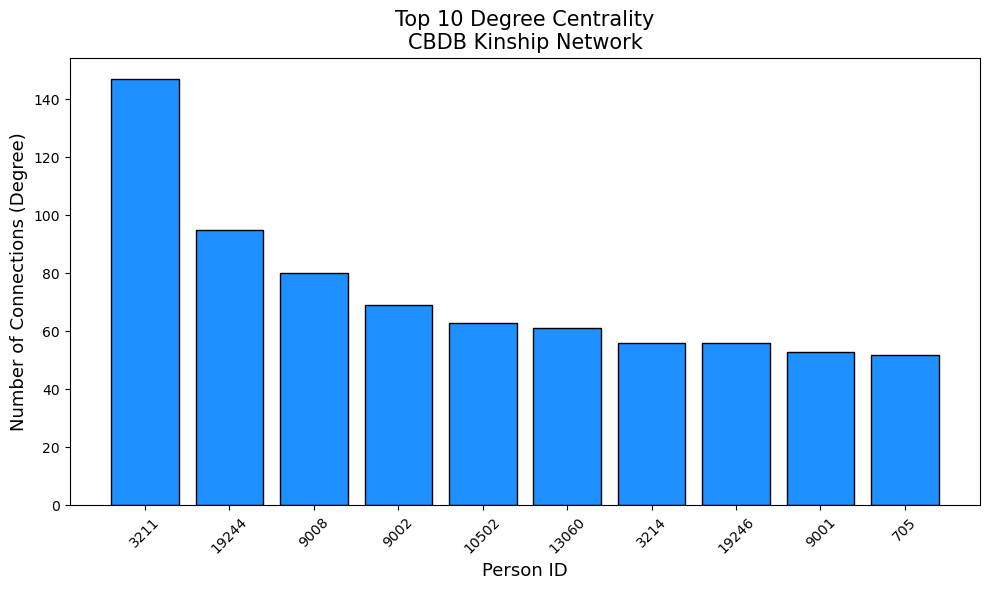

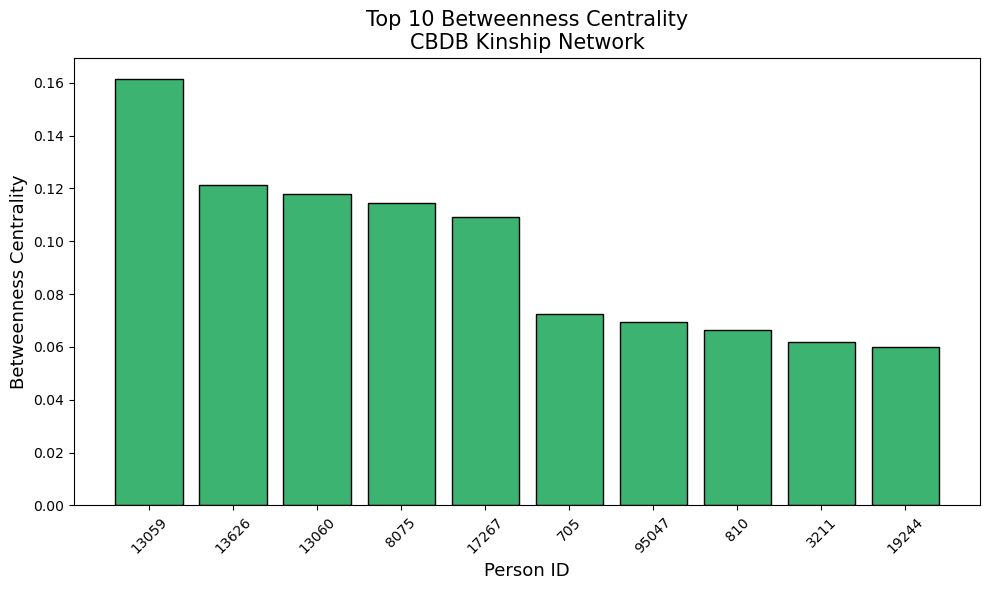

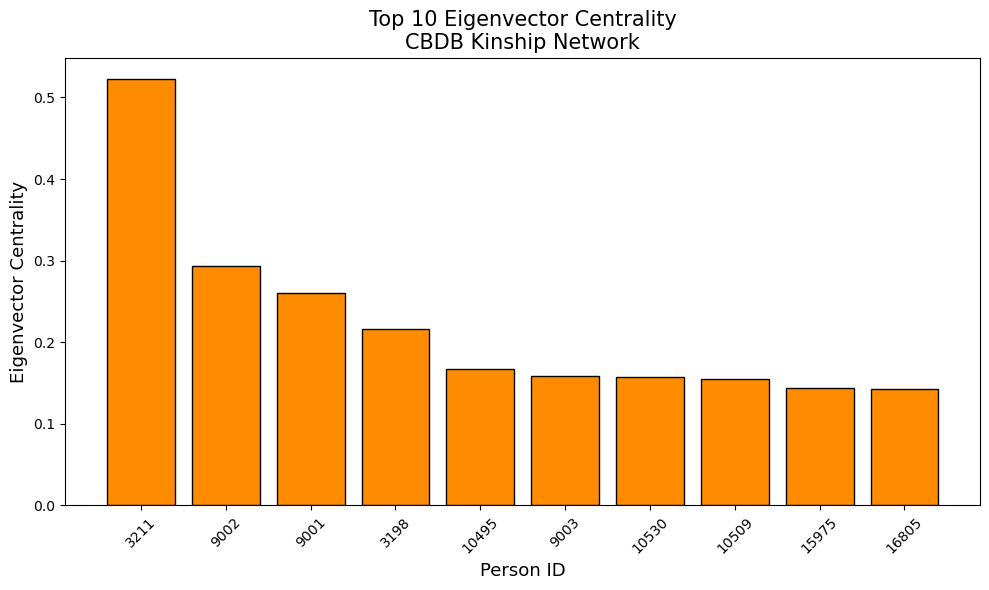

Person 3211 emerges as the most connected individual with 147 kinship
ties, nearly 50% more than the second-most connected person (Person
19244 with 95 connections). This level of connectivity suggests Person
3211 likely represents either a major family patriarch who lived an
exceptionally long life, accumulated multiple marriages and offspring,
or potentially a family line that was consolidated under a single
record. Person 3211 dominates this measure with a score of 0.5228, more
than double the second-highest individual (Person 9002 with 0.2929).
This indicates that Person 3211 is not only highly connected but also
connected to other highly connected families, representing the apex of
elite Chinese society.

Even more striking is Person 17267, who achieves a betweenness
centrality of 0.1092 with only 4 direct connections. This individual
represents what network analysts call a “critical bridge” - someone
whose position in the network gives them disproportionate influence over
information flow and family interactions. In historical Chinese context,
such individuals likely played crucial roles connecting large families
like an emperor or emperor’s wife.

# 3.1 Discussion on Centrality

Using our definitions of the three centrality measures we are using:

-   Degree Centrality: Measures how many direct connections a node
    (person) has. It’s the family member with the most immediate kinship
    ties.
-   Betweeness Centrality: Captures how often a node lies on the
    shortest path between other nodes. It identifies family members who
    act as bridges, connecting separate branches or generations.
-   Eigenvector Centality: Reflects not just the number of connections,
    but also the quality-being connected to other well-connected family
    members. High eigenvector centrality means the person is part of the
    core, influential family group for instance an emperor or very high
    ranking official.

Discuss in small groups of 3-4 people how these centrality measures
exist in your own family and friendship networks. Think about how all
three of these are present in your daily lives. For example do you have
a friend who is really popular (high degree centrality), do you have a
family member who acts as a link between two large families (high
betweeness centrality). Try to link these definitions to real people.

# 3.2 Looking at these key individuals

Looking at our top ten list of key individuals we will examine further
the most standout ones are:

-   Person 3211
-   Person 17267

And our most prominent bridges are below, these nodes have high
betweenness despite having a lower degree, meaning they’re crucial
“gatekeepers” between groups.

-   Person 13059
-   Person 13626
-   Person 8075

Let’s find who these people are.

In [19]:
conn = sqlite3.connect(db_path)

# Key people from the previous network analysis
key_people = [3211, 17267, 13059, 13626, 8075]

# Combined query for biography info + native place
query = f"""
SELECT 
    bm.c_personid,
    bm.c_name_chn,
    bm.c_surname_chn,
    bm.c_name,
    bm.c_surname,
    bm.c_birthyear,
    bm.c_deathyear,
    bm.c_dy,         -- dynasty code
    bm.c_female,
    a.c_name AS NativePlace_CHN
FROM BIOG_MAIN bm
LEFT JOIN BIOG_ADDR_DATA bad
    ON bm.c_personid = bad.c_personid
    AND bad.c_addr_type = 1
LEFT JOIN ADDRESSES a
    ON bad.c_addr_id = a.c_addr_id
WHERE bm.c_personid IN ({",".join(map(str, key_people))})
"""

df = pd.read_sql_query(query, conn)

# Combine name fields into one df
df["FullName_CHN"] = df["c_surname_chn"].fillna('') + df["c_name_chn"].fillna('')
df["FullName_ENG"] = (df["c_surname"].fillna('') + " " + df["c_name"].fillna('')).str.strip()
df["Gender"] = df["c_female"].map({0: "Male", 1: "Female"})

# Keep relevant columns and remove duplicates
final_df = df[[
    "c_personid", "FullName_CHN", "FullName_ENG",
    "c_birthyear", "c_deathyear", "c_dy", "Gender", "NativePlace_CHN"
]].drop_duplicates()

# Display nicely using the display command instead of print
display(final_df)

Now we have the information on our most key people. The people with the
highest degree and eigenvector centrality were Zhao Tingmei and Li Zhao.

[Zhao Tingmei](https://en.wikipedia.org/wiki/Zhao_Tingmei) formally
known as Prince Fudao, was an imperial prince of the Song dynasty. On
the Wikipedia page it states that he had 15 offsprings so it makes sense
that he is so integrated into the network.

The identity of Li Zhao is less clear, but he is most likely [King Li of
Zhou](https://en.wikipedia.org/wiki/King_Li_of_Zhou).

As for our most prominent bridges they are:

-   [Li Fang](https://en.wikipedia.org/wiki/Li_Fang_(Song_dynasty))
-   [Li Yuan(Emperor Gaozu of
    Tang)](https://en.wikipedia.org/wiki/Emperor_Gaozu_of_Tang)
-   Li Yuanyi - I can not find information on him

This is extermenly interesting as we can link all of these nodes to real
people from ancient Chinese history. If we are interested in where they
are from we can also find that using the dataset.

For instance Zhao Tingmei and Li Fang are from Kaifeng. Kaifeng is a
city in central China’s Henan province, just south of the Yellow River.
The city was the Northern Song Dynasty capital from the 10th to 12th
centuries.

Li Yuan (Emperor Gaozu of Tang) and Li Yuanyi are from Chang’an.
Chang’an was a city in China, located near the modern city of Xi’an,
which served as the capital of several Chinese dynasties from 202 BCE to
907 CE.

Finally Li Zhao is from Raoyang, compared to the other two Raoyang is
less historically significant region. Raoyang County is a county in the
southeast of the Hebei province.

# 4.0 Women more as Bridges

Intuitively from the KINMATRIX dataset we would image that women could
act as bridges in these large family networks. An example of this would
be a strategic marriage, but is this the case? We will look at the data
and try to understand if that is the case.

This cell explores the BIOG_MAIN table structure to find the gender
field and loads a sample to understand the data structure. In order to
identify if women act as bridges we need the gender information.

In [20]:
def explore_biog_main():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Explore table structure
    cursor.execute("PRAGMA table_info(BIOG_MAIN)")
    columns = cursor.fetchall()
    print("BIOG_MAIN table columns:")
    for col in columns:
        print(f"  {col[1]} ({col[1]})")
    
    # Test for common gender field names
    gender_fields = ['c_female', 'c_sex', 'c_gender', 'female', 'sex', 'gender']
    gender_field = None
    
    for field in gender_fields:
        try:
            test_query = f"SELECT {field} FROM BIOG_MAIN LIMIT 5"
            cursor.execute(test_query)
            results = cursor.fetchall()
            print(f"\nFound field '{field}' with sample values: {[r[0] for r in results]}")
            gender_field = field
            break
        except:
            continue
        
    conn.close()
    return gender_field

# Run the function
gender_field = explore_biog_main()

The variable we are going to use is **c_female,** it is an indicator
variable which takes the values of 0 or 1; where 1 means the node is
female.

We will now load the data from before, but with the gender variable and
rebuild the network.

In [21]:
def load_network_data():
    conn = sqlite3.connect(db_path)
    
    # Load kinship relationships
    kin_df = pd.read_sql_query("SELECT c_personid, c_kin_id, c_kin_code FROM KIN_DATA", conn)
    print(f"Loaded {len(kin_df):,} kinship relationships")
    
    # Build network graph
    G = nx.Graph()
    for _, row in kin_df.iterrows():
        person = row['c_personid']
        kin = row['c_kin_id']
        kin_type = row['c_kin_code']
        G.add_edge(person, kin, kinship=kin_type)
    
    print(f"Full network: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    
    # Work with largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc).copy()
    print(f"Largest component: {G_sub.number_of_nodes():,} nodes, {G_sub.number_of_edges():,} edges")
    
    conn.close()
    return G_sub, kin_df

# Load the network
G_sub, kin_df = load_network_data()

Because finding centrality is too computationally intensive the cells
will be commented out just like before with their output pasted below.
Just like with the men we will find the Betweenness, Closeness and
Eigenvector centrality.

Instead of using the whole data we will also be using the largest
component of the data which is made up of 52,992 nodes, and 65,269 edges
(still very large).

In [22]:
#def create_centrality_dataframe(G_sub, degree_centrality, betweenness_centrality, 
#                               closeness_centrality, eigenvector_centrality):

    # Create comprehensive centrality dataframe using your existing variables
#    analysis_df = pd.DataFrame({
#        'person_id': list(G_sub.nodes()),
#        'degree': [G_sub.degree(node) for node in G_sub.nodes()],
#        'degree_centrality': [degree_centrality[node] for node in G_sub.nodes()],
#        'betweenness_centrality': [betweenness_centrality[node] for node in G_sub.nodes()],
#        'closeness_centrality': [closeness_centrality[node] for node in G_sub.nodes()],
#       'eigenvector_centrality': [eigenvector_centrality[node] for node in G_sub.nodes()]
#    })
    
#    print(f"Centrality analysis complete for {len(analysis_df):,} individuals")
#    print(f"Average degree: {analysis_df['degree'].mean():.2f}")
#    print(f"Average betweenness centrality: {analysis_df['betweenness_centrality'].mean():.6f}")
#    print(f"Average closeness centrality: {analysis_df['closeness_centrality'].mean():.6f}")
#    print(f"Average eigenvector centrality: {analysis_df['eigenvector_centrality'].mean():.6f}")
    
#    return analysis_df

# Use your existing centrality calculations (no recalculation needed!)
#centrality_df = create_centrality_dataframe(G_sub, degree_centrality, betweenness_centrality, closeness_centrality, eigenvector_centrality)

Centrality analysis complete for 52,992 individuals:

-   Average degree: 2.46
-   Average betweenness centrality: 0.000342
-   Average closeness centrality: 0.054518
-   Average eigenvector centrality: 0.000279

The next step is to load gender data from the database and add our
gender variable:

-   Gender field = c_female
-   Birth year field = c_birthyear
-   Death year field = c_deathyear
-   Index year field = c_index_year

We still need centrality so this cell will also be commented out:

In [23]:
#}#def load_and_merge_gender_data(centrality_df, gender_field='c_female'):
#    """Load gender & year data from BIOG_MAIN and merge with centrality_df"""
#    conn = sqlite3.connect(db_path)

#    biog_query = f"""
#        SELECT 
#            c_personid, 
#            c_name_chn, 
#            c_name,
#            {gender_field} AS gender,
#            c_birthyear,
#            c_deathyear,
#            c_index_year
#        FROM BIOG_MAIN
#        WHERE {gender_field} IS NOT NULL
#    """
#    biog_df = pd.read_sql_query(biog_query, conn)
#    conn.close()
#    print(f"Loaded {len(biog_df):,} individuals with gender info")
#    merged_df = centrality_df.merge(
#        biog_df[['c_personid', 'gender', 'c_birthyear', 'c_deathyear', 'c_index_year']],
#        left_on='person_id',
#        right_on='c_personid',
#        how='left'
#    )
    # Gender distribution
#    print("\nGender distribution (0=male, 1=female):")
#    print(merged_df['gender'].value_counts(dropna=False))

#    coverage = merged_df['gender'].notna().sum() / len(merged_df) * 100
#    print(f"Gender data coverage: {coverage:.1f}% of network nodes")

#    return merged_df

#final_df = load_and_merge_gender_data(centrality_df, gender_field='c_female')

**Output:** Gender distribution (0=male, 1=female):

-   0 48869
-   1 4123

Name: count, dtype: int64 Gender data coverage: 100.0% of network nodes

We can see from the output that the majority of nodes are male which is
something which we saw with the Pyvis visualization. This gender
inconsistency makes sense as for historical records they are more likely
to record men espeically for ones going back to the 7th century. In the
largest component we are using only 7.8% of the nodes are female. This
might not end up being an issue as it is possible for women to still be
stronger bridges except for a few outlier men.

In [24]:
#final_df['gender_label'] = final_df['gender'].map({0: 'Male', 1: 'Female'})
#bridge_thresh = 0.001 #Define a 'bridge' threshold

#female_bridges = final_df[(final_df['gender_label'] == 'Female') & 
#                          (final_df['betweenness_centrality'] > bridge_thresh)]
#male_bridges = final_df[(final_df['gender_label'] == 'Male') & 
#                        (final_df['betweenness_centrality'] > bridge_thresh)]

#n_female = (final_df['gender_label'] == 'Female').sum()
#n_male = (final_df['gender_label'] == 'Male').sum()

#prop_female_bridges = len(female_bridges) / n_female * 100 if n_female else 0
#prop_male_bridges = len(male_bridges) / n_male * 100 if n_male else 0

#print(f"Females with betweenness > {bridge_thresh}: {len(female_bridges)} / {n_female} ({prop_female_bridges:.2f}%)")
#print(f"Males with betweenness > {bridge_thresh}: {len(male_bridges)} / {n_male} ({prop_male_bridges:.2f}%)")

Output:

-   Females with betweenness \> 0.001: 101 / 4123 (2.45%)
-   Males with betweenness \> 0.001: 4452 / 48869 (9.11%)

We can see that 9.11% percent of men pass our treshold of 0.001 while
only 2.45% of women, so most of the main ‘bridges’ in our dataset are
men.

In [25]:
#final_df['gender_label'] = final_df['gender'].map({0: 'Male', 1: 'Female'})

#bridge_thresh = 0.01 # Define a 'bridge' threshold 

#female_bridges = final_df[(final_df['gender_label'] == 'Female') & 
#                          (final_df['betweenness_centrality'] > bridge_thresh)]
#male_bridges = final_df[(final_df['gender_label'] == 'Male') & 
#                        (final_df['betweenness_centrality'] > bridge_thresh)]

#n_female = (final_df['gender_label'] == 'Female').sum()
#n_male = (final_df['gender_label'] == 'Male').sum()

#prop_female_bridges = len(female_bridges) / n_female * 100 if n_female else 0
#prop_male_bridges = len(male_bridges) / n_male * 100 if n_male else 0

#print(f"Females with betweenness > {bridge_thresh}: {len(female_bridges)} / {n_female} ({prop_female_bridges:.2f}%)")
#print(f"Males with betweenness > {bridge_thresh}: {len(male_bridges)} / {n_male} ({prop_male_bridges:.2f}%)")

Output: \* Females with betweenness \> 0.01: 5 / 4123 (0.12%) \* Males
with betweenness \> 0.01: 205 / 48869 (0.42%)

If we up our treshhold we can see that this does not change with 0.42%
men compared to 0.12% women passing our treshhold of 0.01. This means
that women in our dataset do not act as bridges more than men. Still
let’s look at the most prominent female bridges and like with the men
link them to real historical figures.

In [26]:
#top_female_bridges = final_df[final_df['gender_label'] == 'Female'].nlargest(10, 'betweenness_centrality')
#print("Top 10 Female Bridges in the Network:")
#for i, row in top_female_bridges.iterrows():
#    print(f"Person {row['person_id']}: Betweenness={row['betweenness_centrality']:.3f}, Degree={row['degree']}")

Top 10 Female Bridges in the Network:

-   Person 141303: Betweenness=0.037, Degree=12
-   Person 93663: Betweenness=0.029, Degree=28
-   Person 17702: Betweenness=0.015, Degree=11
-   Person 142641: Betweenness=0.011, Degree=6
-   Person 140204: Betweenness=0.010, Degree=5
-   Person 4217: Betweenness=0.009, Degree=12
-   Person 141789: Betweenness=0.009, Degree=12
-   Person 194260: Betweenness=0.009, Degree=8
-   Person 134070: Betweenness=0.009, Degree=3
-   Person 141996: Betweenness=0.008, Degree=15

As with the best male connectors let’s find the identies of the top 3
female bridges:

-   Person 141303: Betweenness=0.037, Degree=12
-   Person 93663: Betweenness=0.029, Degree=28
-   Person 17702: Betweenness=0.015, Degree=11

In [27]:
conn = sqlite3.connect(db_path)

# Key people
key_women = [141303, 93663, 17702]

# Combined query for biography + native place
query = f"""
SELECT 
    bm.c_personid,
    bm.c_name_chn,
    bm.c_surname_chn,
    bm.c_name,
    bm.c_surname,
    bm.c_birthyear,
    bm.c_deathyear,
    bm.c_dy,         -- dynasty code
    bm.c_female,
    a.c_name AS NativePlace_CHN
FROM BIOG_MAIN bm
LEFT JOIN BIOG_ADDR_DATA bad
    ON bm.c_personid = bad.c_personid
    AND bad.c_addr_type = 1
LEFT JOIN ADDRESSES a
    ON bad.c_addr_id = a.c_addr_id
WHERE bm.c_personid IN ({",".join(map(str, key_women))})
"""

# Read into dataframe
df = pd.read_sql_query(query, conn)

# Combine name fields
df["FullName_CHN"] = df["c_surname_chn"].fillna('') + df["c_name_chn"].fillna('')
df["FullName_ENG"] = (df["c_surname"].fillna('') + " " + df["c_name"].fillna('')).str.strip()
df["Gender"] = df["c_female"].map({0: "Male", 1: "Female"})

# Keep relevant columns and remove duplicates
final_df = df[[
    "c_personid", "FullName_CHN", "FullName_ENG",
    "c_birthyear", "c_deathyear", "c_dy", "Gender", "NativePlace_CHN"
]].drop_duplicates()

# Display nicely
display(final_df)

The top women ‘bridges’ in our dataset are:

-   Wu Shi: who is the wife of [Emperor Gaozong of
    Song](https://en.wikipedia.org/wiki/Emperor_Gaozong_of_Song). It
    says in the data that she is from Qiantang which is a river near
    Shanghai.
-   [Wu Zhao(Wu Zetian)](https://en.wikipedia.org/wiki/Wu_Zetian) who
    was empress of China from 660 to 705, ruling first through others
    and later in her own right. She ruled as empress through her husband
    Emperor Gaozong and later as empress dowager through her sons
    Emperors Zhongzong and Ruizong, from 660 to 690. She is from Wenshui
    which is “a county in the west-central part of Shanxi Province,
    China.””
-   Cui Sui is most likely daugher of [Cui Ting
    Shi](https://en.wikipedia.org/wiki/Cui_Shi). She is from Qinghe
    which is “located in the south of Hebei province, China, bordering
    Shandong province to the east.”

# 5.0 Networks over time and Across Dynasties

Next we will look at the dynasties over time and try to determine if
there are quantifiable differences between the networks for each of
these dynasties.

To determine the dynasty we will use the `c_index_year` variable and if
that does not exist as a substitute we will use `c_birthyear`. We have
repeated this analysis with the `c_dynasty` variable the findings were
nearly identical, but the code was more complicated so we have settled
on this version.

Load more data and define dynasties.

In [28]:
conn = sqlite3.connect(db_path)
biog_df = pd.read_sql_query("""
    SELECT c_personid, c_birthyear, c_deathyear, c_index_year
    FROM BIOG_MAIN""", conn)

def assign_dynasty(row):
    year = row['c_index_year']
    if year is None:
        year = row['c_birthyear'] 
    if year is None:
        return 'Unknown'
    if 0 <= year <= 618: return 'Pre-Tang'
    if 618 <= year <= 907: return 'Tang'
    if 907 < year < 960: return 'Five Dynasties/10 Kingdoms'
    if 960 <= year <= 1279: return 'Song'
    if 1279 <= year <= 1368: return 'Yuan'
    if 1368 <= year <= 1644: return 'Ming'
    if 1644 <= year <= 1912: return 'Qing'
    if 1912 <= year <= 2025: return 'Modern'
    return 'Other'

biog_df['dynasty'] = biog_df.apply(assign_dynasty, axis=1)
conn.close()

#uncomment if we want to see sorted by ammount
#print(biog_df['dynasty'].value_counts())

In [29]:
#order from before just cleanly defined
dynasty_order = [
    'Pre-Tang',
    'Tang',
    'Five Dynasties/10 Kingdoms',
    'Song',
    'Yuan',
    'Ming',
    'Qing',
    'Modern',
    'Other'   
    ]

biog_df['dynasty'] = pd.Categorical(
    biog_df['dynasty'],
    categories=dynasty_order,
    ordered=True
)

#Print in order
#print(biog_df['dynasty'].value_counts(sort=False))

Now we will filter by dynasties and create NetworkX objects for each
dynasty. We will be able to see how many nodes and edges each dynasty
has.

In [30]:
# Define custom dynasty order
dynasty_order = [
    'Pre-Tang',
    'Tang',
    'Five Dynasties/10 Kingdoms',
    'Song',
    'Yuan',
    'Ming',
    'Qing',
    'Modern',
    'Other'
]

# Load kinship relationships
conn = sqlite3.connect(db_path)
kin_df = pd.read_sql_query("SELECT c_personid, c_kin_id FROM KIN_DATA", conn)
conn.close()

# Merge dynasty info for person and kin
kin_df = kin_df.merge(
    biog_df[['c_personid', 'dynasty']],
    left_on='c_personid', right_on='c_personid',
    how='left'
)
kin_df = kin_df.merge(
    biog_df[['c_personid', 'dynasty']],
    left_on='c_kin_id', right_on='c_personid',
    how='left',
    suffixes=('_person', '_kin')
)

# Ensure dynasty columns are ordered categorical
kin_df['dynasty_person'] = pd.Categorical(
    kin_df['dynasty_person'],
    categories=dynasty_order,
    ordered=True
)
kin_df['dynasty_kin'] = pd.Categorical(
    kin_df['dynasty_kin'],
    categories=dynasty_order,
    ordered=True
)

def build_dynasty_networks(kin_df):
    dynasty_graphs = {}
    for dyn in dynasty_order:
        if dyn in kin_df['dynasty_person'].values:
            sub_edges = kin_df[kin_df['dynasty_person'] == dyn]
            G = nx.Graph()
            G.add_edges_from(zip(sub_edges['c_personid_person'], sub_edges['c_kin_id']))
            dynasty_graphs[dyn] = G
            print(f"Dynasty {dyn}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return dynasty_graphs

dynasty_graphs = build_dynasty_networks(kin_df)

The output is great, we can see that most of the data has a
corresponding dynasty. There is very little modern as the scope of the
dataset is from the 7th through the 19th century so this makes sense. We
can ignore other, and modern for this analysis.

Now we will calculate Degree Centrality, Density, Clustering
Coefficient, and Modularity for our dynasties. This will serve as the
first step towards trying to find differences or similarities between
these dynasties.

In [31]:
# List of included dynasties in order
ordered_dynasties = ["Pre-Tang", "Tang", "Five Dynasties/10 Kingdoms", "Song", "Yuan", "Ming", "Qing"]

def analyze_dynasty_metrics_selected(dynasty_graphs, ordered_dynasties):
    results = {}
    for dyn_name in ordered_dynasties:
        G = dynasty_graphs.get(dyn_name)
        if G is None:
            continue
        # Degree centrality
        deg_cent = nx.degree_centrality(G)
        avg_deg_cent = sum(deg_cent.values()) / len(deg_cent)

        # Average degree per node
        avg_degree = (2 * G.number_of_edges()) / G.number_of_nodes()

        # Graph density
        density = nx.density(G)

        # Clustering coefficient (average)
        avg_clust = nx.average_clustering(G)

        # Community detection: modularity
        communities = list(nx.community.greedy_modularity_communities(G))
        modularity = nx.community.modularity(G, communities)

        results[dyn_name] = {
            "avg_degree_centrality": avg_deg_cent,
            "avg_degree": avg_degree,
            "density": density,
            "avg_clustering_coefficient": avg_clust,
            "modularity": modularity
        }
        print(f"{dyn_name}: Avg Degree Centrality={avg_deg_cent:.4f}, Avg Degree={avg_degree:.2f}, "
              f"Density={density:.6f}, Avg Clust Coeff={avg_clust:.4f}, Modularity={modularity:.4f}")
    return results

#Run the function
dynasty_metrics_selected = analyze_dynasty_metrics_selected(dynasty_graphs, ordered_dynasties)

From findings we will see that Degree Centrality and Density are very
small these are expected because of the huge size of the network. We
also have very high modularity near 1, as expected in a family network
there are strong community structures. Song has the highest Average
Degree for each node at 2.38 which is far more than the other dynasties.
Let’s continue with our analysis.

Degree Distribution Shape Analysis

In [32]:
def analyze_degree_distributions(dynasty_graphs, ordered_dynasties):
    plt.figure(figsize=(15, 10))
    
    for i, dyn_name in enumerate(ordered_dynasties):
        G = dynasty_graphs.get(dyn_name)
        if G is None:
            continue
            
        degrees = [d for n, d in G.degree()]
        
        # Plot distribution
        plt.subplot(3, 3, i+1)
        plt.hist(degrees, bins=50, alpha=0.7, color=f'C{i}')
        plt.title(f'{dyn_name} Degree Distribution')
        plt.xlabel('Degree')
        plt.ylabel('Frequency')
        plt.yscale('log')  # Log scale to see heavy tails
        
        # Calculate distribution statistics
        mean_deg = np.mean(degrees)
        median_deg = np.median(degrees)
        max_deg = max(degrees)
        std_deg = np.std(degrees)
        skewness = stats.skew(degrees)
        
        print(f"{dyn_name}: Mean={mean_deg:.2f} "
              f"Std={std_deg:.2f}, Skewness={skewness:.2f}")
    
    plt.tight_layout()
    plt.show()

# Run analysis
analyze_degree_distributions(dynasty_graphs, ordered_dynasties)

Our visualization is a histogram of the frequency of high degree nodes.
All of them are similar except for the Ming Dynasty.

There are many potential reasons for this, but one that stands out is
the Ming Dynasties unique approach to scholar network formation and
bureaucratic recruitment, which created a more centralized and
hierarchical system compared to other Chinese dynasties. This very
selective system created a different social network structure than
previous dynasties. The Ming examination system produced a small core of
connected scholars and officials who formed the adminstrative portion of
the government. Unlike earlier dynasties where multiple pathways to
office existed, the Ming system funneled nearly all political
advancement through this single, narrow channel. This single channel was
a series of exams which 2-3 million applicants would attempt per year
with only about a thousand passing. This process lead to a social
network which was more evenly connected than previous or future
dynasties.

We will continue our analysis with looking at how many components each
dynasty has and their fragmentation and average size.

In [33]:
def analyze_connected_components(dynasty_graphs, ordered_dynasties):
    results = {}
    
    for dyn_name in ordered_dynasties:
        G = dynasty_graphs.get(dyn_name)
        if G is None:
            continue
            
        # Get connected components
        components = list(nx.connected_components(G))
        num_components = len(components)
        component_sizes = [len(c) for c in components]
        
        # Calculate metrics
        largest_component_size = max(component_sizes) if component_sizes else 0
        fragmentation_index = 1 - (largest_component_size / G.number_of_nodes())
        avg_component_size = np.mean(component_sizes) if component_sizes else 0
        
        results[dyn_name] = {
            "num_components": num_components,
            "largest_component_size": largest_component_size,
            "fragmentation_index": fragmentation_index,
            "avg_component_size": avg_component_size,
            "component_sizes": component_sizes
        }
        
        print(f"{dyn_name}: Components={num_components}, "
              f"Largest={largest_component_size}, "
              f"Fragmentation={fragmentation_index:.4f}, "
              f"Avg Size={avg_component_size:.2f}")
    
    return results

# Run analysis
component_results = analyze_connected_components(dynasty_graphs, ordered_dynasties)

As expected the Pre-Tang dynasty is quite disconnected with many smaller
clusters. The Song dynasty has the lowest fragmentation and the largest
component meaning most of the network for this dynasty is one large
component. The Yuan dynasty is also very fragmented which is suprising
as it covered a large political period. The Ming dynasty has the most
components by far but a minuscule largest connected cluster. In general
dynasties before Yuan have quite low fragmentation compared to ones
after Yuan.

We will contunue with temporal patterning analysis to see if within
these dynasties there were large changes throughout the years.

We will use the *‘c_index_year’* variable to see if density, clustering,
or average degree changes over time change inside a dynasty.

In [34]:
def analyze_temporal_patterns(kin_df, biog_df, ordered_dynasties):
    # Merge to get information for each edge
    kin_temporal = kin_df.merge(biog_df[['c_personid', 'c_index_year', 'dynasty']], 
                               left_on='c_personid_person', right_on='c_personid', how='left')
    
    results = {}
    
    for dyn_name in ordered_dynasties:
        dyn_data = kin_temporal[kin_temporal['dynasty_person'] == dyn_name].copy()
        
        # Group by time periods (for us 50-year bins)
        if dyn_data['c_index_year'].notna().sum() > 0:
            min_year = int(dyn_data['c_index_year'].min())
            max_year = int(dyn_data['c_index_year'].max())
            bins = range(min_year, max_year + 50, 50)
            dyn_data['time_bin'] = pd.cut(dyn_data['c_index_year'], bins=bins)
            
            # Calculate metrics per time period
            temporal_metrics = []
            for time_bin in dyn_data['time_bin'].cat.categories:
                bin_data = dyn_data[dyn_data['time_bin'] == time_bin]
                if len(bin_data) > 10:  # Only analyze bins with sufficient data
                    # Create subgraph for this time period
                    edges = zip(bin_data['c_personid_person'], bin_data['c_kin_id'])
                    temp_G = nx.Graph()
                    temp_G.add_edges_from(edges)
                    
                    if temp_G.number_of_nodes() > 0:
                        avg_deg = (2 * temp_G.number_of_edges()) / temp_G.number_of_nodes()
                        density = nx.density(temp_G)
                        clustering = nx.average_clustering(temp_G)
                        
                        temporal_metrics.append({
                            'time_period': str(time_bin),
                            'avg_degree': avg_deg,
                            'density': density,
                            'clustering': clustering,
                            'nodes': temp_G.number_of_nodes(),
                            'edges': temp_G.number_of_edges()
                        })
            
            results[dyn_name] = temporal_metrics
            
            # Print summary
            print(f"\n{dyn_name} Temporal Analysis ({min_year}-{max_year}):")
            for metric in temporal_metrics[:20]:  # Show first 20 time periods (which is all)
                print(f"  {metric['time_period']}: Avg Degree={metric['avg_degree']:.2f}, "
                      f"Density={metric['density']:.6f}, Clustering={metric['clustering']:.4f}")
    
    return results

# Run temporal analysis
temporal_results = analyze_temporal_patterns(kin_df, biog_df, ordered_dynasties)

The findings here are quite interesting there seems to be quite a bit of
variation inside of the dynasties.

-   Pre-Tang: The clustering increases through the years which makes
    sense.
-   Tang: The average degre is quite stable with a slight spike in the
    middle. Clustering gradually increases from very low (0.0210) to
    peak at mid-period (0.0667), then drops similar to average degree.
-   Five Dynasties/10 Kingdoms Temporal Analysis: Large drop in Average
    Degree, with a very large decrease in clustering from (0.0755 to
    0.0106)
-   Song: Late Song becomes more clustered and somewhat denser compared
    to early Song.
-   Yuan: Large drop in average degree (1.94 to 1.59) and large decrease
    in clustering (0.1219 to 0.0221)
-   Ming: Very stable compared to other dynasties
-   Qing: Early Qing is more cohesive than late Qing except for a late
    density spike that is not accompanied by clustering.

# 6.0 Citations

Al-Taie, M. Z., & Kadry, S. (2017). *Python for graph and network
analysis*. Springer. https://doi.org/10.1007/978-3-319-53004-8

Cartwright, Mark. “The Civil Service Examinations of Imperial China.”
World History Encyclopedia, https://www.worldhistory.org#organization,
15 Aug. 2025,
www.worldhistory.org/article/1335/the-civil-service-examinations-of-imperial-china/.

“Chang’an.” Wikipedia, Wikimedia Foundation, 10 Aug. 2025,
en.wikipedia.org/wiki/Chang%27an.

“China Biographical Database Project (CBDB).” Home, Harvard, 2024,
projects.iq.harvard.edu/cbdb/home.

“The China Biographical Database User’s Guide.” The China Biographical
Database, Harvard, 26 July 2024,
projects.iq.harvard.edu/sites/projects.iq.harvard.edu/files/cbdb/files/cbdb_users_guide.pdf.

“Cui Shi.” Wikipedia, Wikimedia Foundation, 18 July 2025,
en.wikipedia.org/wiki/Cui_Shi. “Dynasties of China.” Wikipedia,
Wikimedia Foundation, 27 July 2025,
en.wikipedia.org/wiki/Dynasties_of_China.

“Emperor Gaozong of Song.” Wikipedia, Wikimedia Foundation, 18 July
2025, en.wikipedia.org/wiki/Emperor_Gaozong_of_Song.

“Emperor Gaozu of Tang.” Wikipedia, Wikimedia Foundation, 2 Aug. 2025,
en.wikipedia.org/wiki/Emperor_Gaozu_of_Tang.

“Kaifeng.” Wikipedia, Wikimedia Foundation, 11 Aug. 2025,
en.wikipedia.org/wiki/Kaifeng.

“King Li of Zhou.” Wikipedia, Wikimedia Foundation, 20 July 2025,
en.wikipedia.org/wiki/King_Li_of_Zhou.

“Li Fang (Song Dynasty).” Wikipedia, Wikimedia Foundation, 27 May 2025,
en.wikipedia.org/wiki/Li_Fang\_(Song_dynasty).

“Ming Dynasty.” Encyclopedia Britannica, Encyclopedia Britannica, inc.,
31 July 2025, www.britannica.com/topic/Ming-dynasty-Chinese-history.

“Qiantang River.” Wikipedia, Wikimedia Foundation, 23 July 2025,
en.wikipedia.org/wiki/Qiantang_River.

“Qinghe County, Hebei.” Wikipedia, Wikimedia Foundation, 2 Aug. 2025,
en.wikipedia.org/wiki/Qinghe_County,\_Hebei.

“Raoyang County.” Wikipedia, Wikimedia Foundation, 28 Feb. 2025,
en.wikipedia.org/wiki/Raoyang_County.

“Song Dynasty.” Encyclopedia Britannica, Encyclopædia Britannica, inc.,
17 July 2025, www.britannica.com/topic/Song-dynasty.

“Tang Dynasty.” Encyclopedia Britannica, Encyclopædia Britannica, inc.,
19 July 2025, www.britannica.com/topic/Tang-dynasty.

“Wenshui County.” Wikipedia, Wikimedia Foundation, 12 Aug. 2024,
en.wikipedia.org/wiki/Wenshui_County.

“Wu Zetian.” Wikipedia, Wikimedia Foundation, 10 Aug. 2025,
en.wikipedia.org/wiki/Wu_Zetian.

“Zhao Tingmei.” Wikipedia, Wikimedia Foundation, 10 Feb. 2025,
en.wikipedia.org/wiki/Zhao_Tingmei.